In [1]:
# --- BLOCK 1: SETUP & LOAD ---
!pip install pm4py

import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    import cudf.pandas
    if cudf.pandas.get_option('mode.pandas_on_cudf'):
        cudf.pandas.set_option('mode.pandas_on_cudf', False)
except (ImportError, AttributeError):
    pass

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

filename = '18_12_Filtered_Log_100%.csv'
df = pd.read_csv(filename)

df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
df['case:concept:name'] = df['case:concept:name'].astype(str)
df['concept:name'] = df['concept:name'].astype(str)

print(f"Dataset loaded: {len(df)} events, {len(df['case:concept:name'].unique())} cases.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.6 MB/s eta 0:00:00
Dataset loaded: 16826 events, 1820 cases.


/tmp/ipython-input-2284768123.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=variants_df.head(10), y='Count', x=variants_df.head(10).index, palette="viridis")


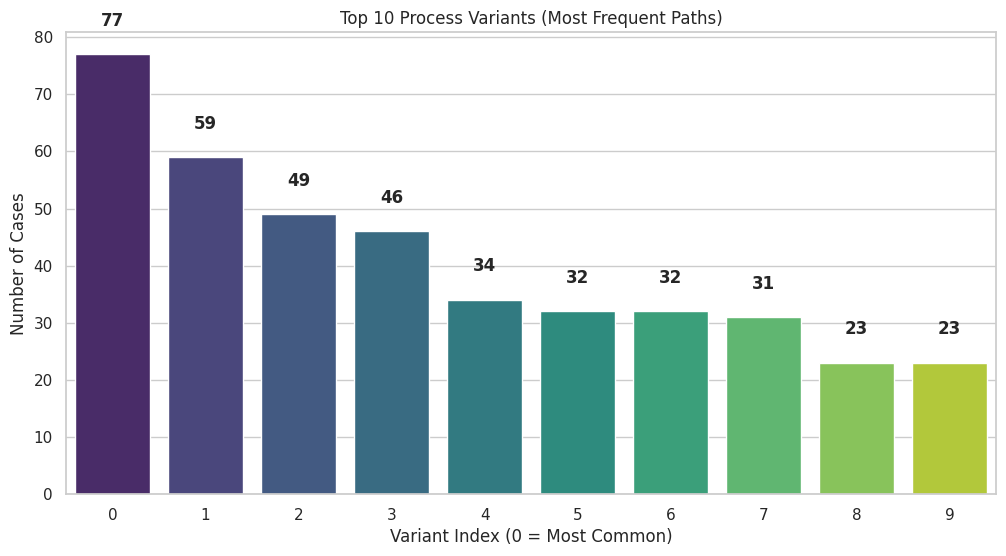


--- HAPPY PATH (Variant 0 - 4.23% of cases) ---
Enter the ED -> Triage in the ED -> Vital sign check -> Discharge from the ED

The top 10 variants cover 22.31% of all patients.


In [2]:
# --- BLOCK 2: VARIANT ANALYSIS ---
variants = pm4py.get_variants_as_tuples(df)
total_cases = len(df['case:concept:name'].unique())

variants_list = [{'Variant': var, 'Count': count} for var, count in variants.items()]
variants_df = pd.DataFrame(variants_list).sort_values(by='Count', ascending=False).reset_index(drop=True)
variants_df['Percentage'] = (variants_df['Count'] / total_cases) * 100
variants_df['Cumulative'] = variants_df['Percentage'].cumsum()

plt.figure(figsize=(12, 6))
sns.barplot(data=variants_df.head(10), y='Count', x=variants_df.head(10).index, palette="viridis")
plt.title('Top 10 Process Variants (Most Frequent Paths)')
plt.xlabel('Variant Index (0 = Most Common)')
plt.ylabel('Number of Cases')
for i, v in enumerate(variants_df.head(10)['Count']):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.show()

top_variant = variants_df.iloc[0]['Variant']
print(f"\n--- HAPPY PATH (Variant 0 - {variants_df.iloc[0]['Percentage']:.2f}% of cases) ---")
print(" -> ".join(top_variant))
print(f"\nThe top 10 variants cover {variants_df.head(10)['Percentage'].sum():.2f}% of all patients.")

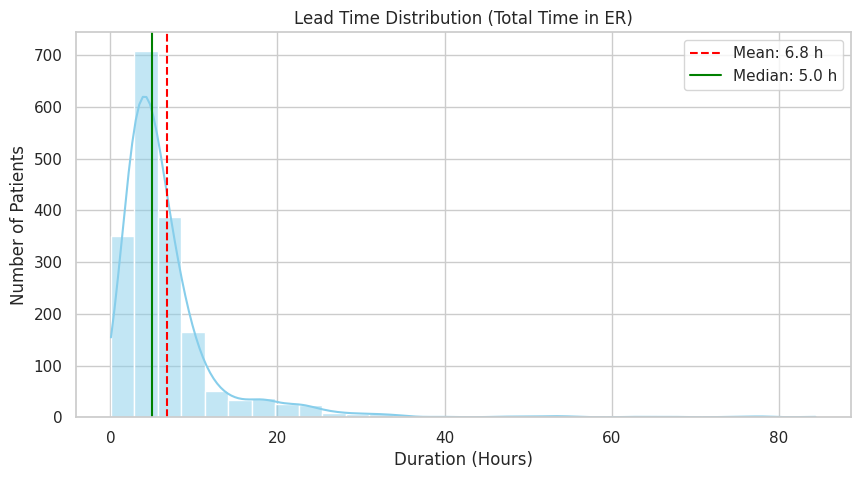

/tmp/ipython-input-1474920927.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=case_level_df, x='acuity', y='Total_Duration_Hours', palette="Reds_r", showfliers=False)


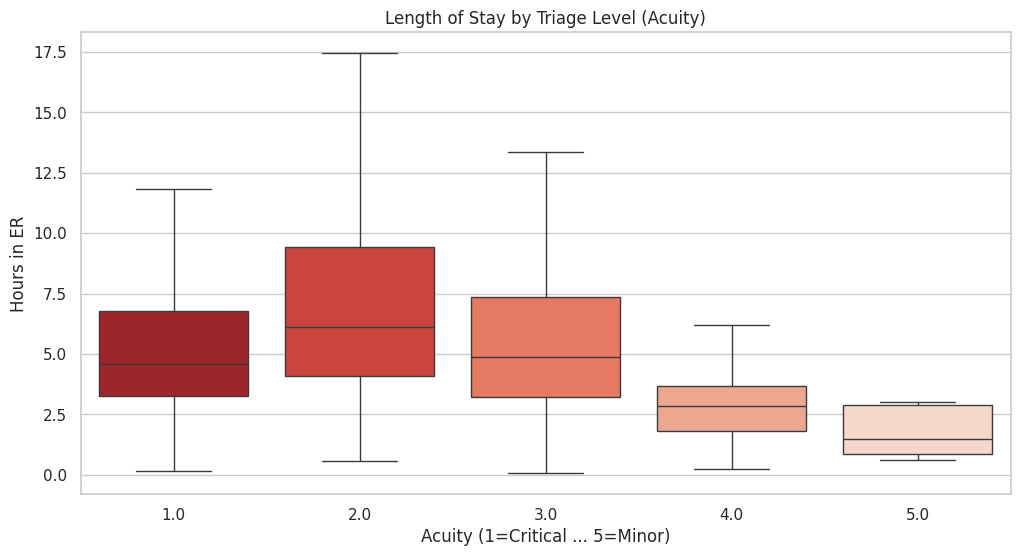

/tmp/ipython-input-1474920927.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=case_level_df, x='disposition', y='Total_Duration_Hours', palette="Set2", showfliers=False)


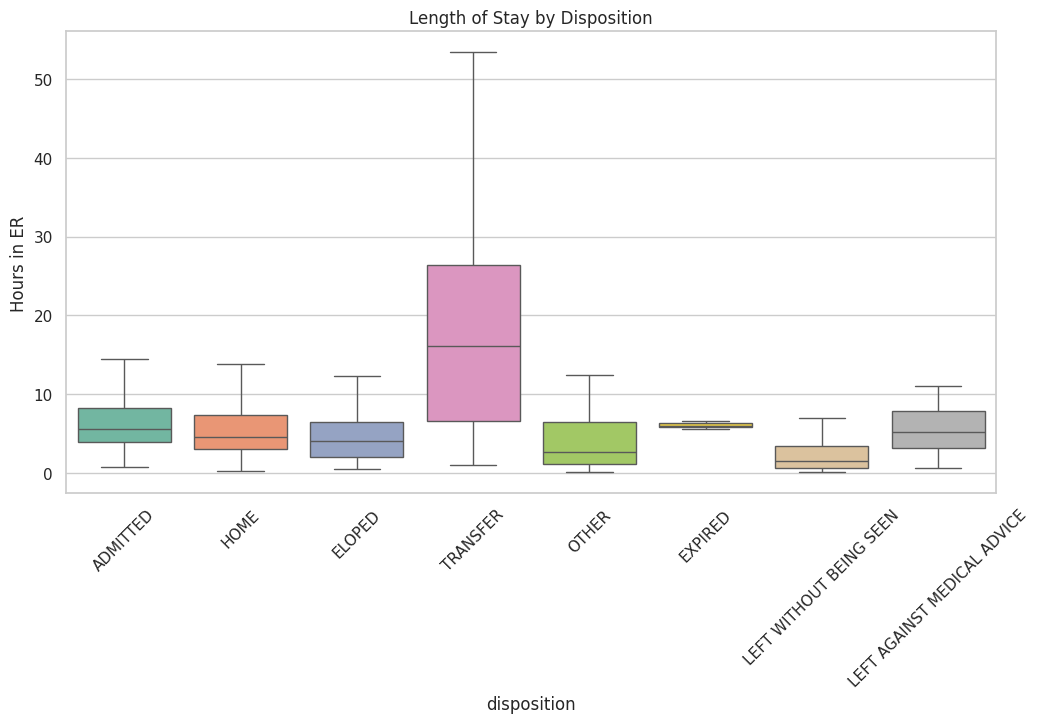

In [3]:
# --- BLOCK 3: PERFORMANCE ANALYSIS ---
case_durations = pm4py.get_all_case_durations(df)
case_durations_hours = [d / 3600 for d in case_durations]

plt.figure(figsize=(10, 5))
sns.histplot(case_durations_hours, bins=30, kde=True, color="skyblue")
plt.title('Lead Time Distribution (Total Time in ER)')
plt.xlabel('Duration (Hours)')
plt.ylabel('Number of Patients')
plt.axvline(np.mean(case_durations_hours), color='red', linestyle='--', label=f'Mean: {np.mean(case_durations_hours):.1f} h')
plt.axvline(np.median(case_durations_hours), color='green', linestyle='-', label=f'Median: {np.median(case_durations_hours):.1f} h')
plt.legend()
plt.show()

case_level_df = df.groupby('case:concept:name').first().reset_index()
case_level_df['Total_Duration_Hours'] = df.groupby('case:concept:name')['time:timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600).values

plt.figure(figsize=(12, 6))
sns.boxplot(data=case_level_df, x='acuity', y='Total_Duration_Hours', palette="Reds_r", showfliers=False)
plt.title('Length of Stay by Triage Level (Acuity)')
plt.xlabel('Acuity (1=Critical ... 5=Minor)')
plt.ylabel('Hours in ER')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=case_level_df, x='disposition', y='Total_Duration_Hours', palette="Set2", showfliers=False)
plt.title('Length of Stay by Disposition')
plt.xticks(rotation=45)
plt.ylabel('Hours in ER')
plt.show()

Generating Frequency Map...


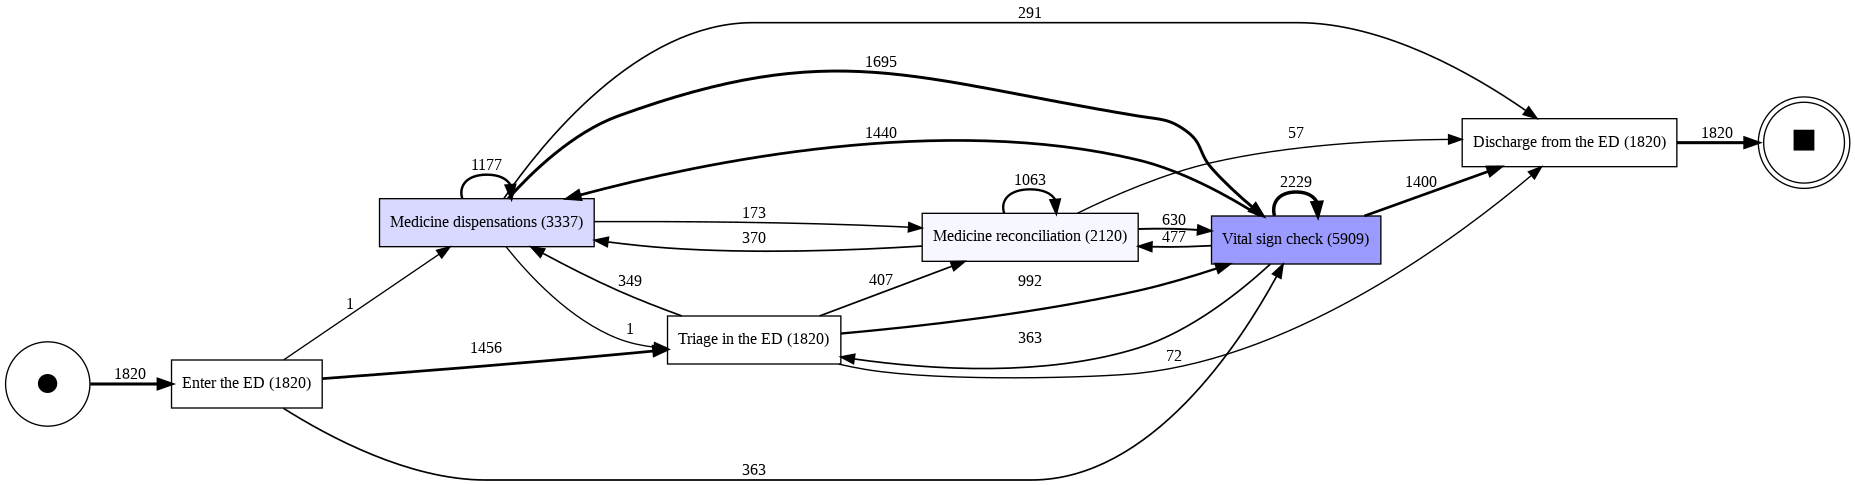


Generating Performance Map...
Error generating Performance DFG: cannot subtract DatetimeArray from ndarray


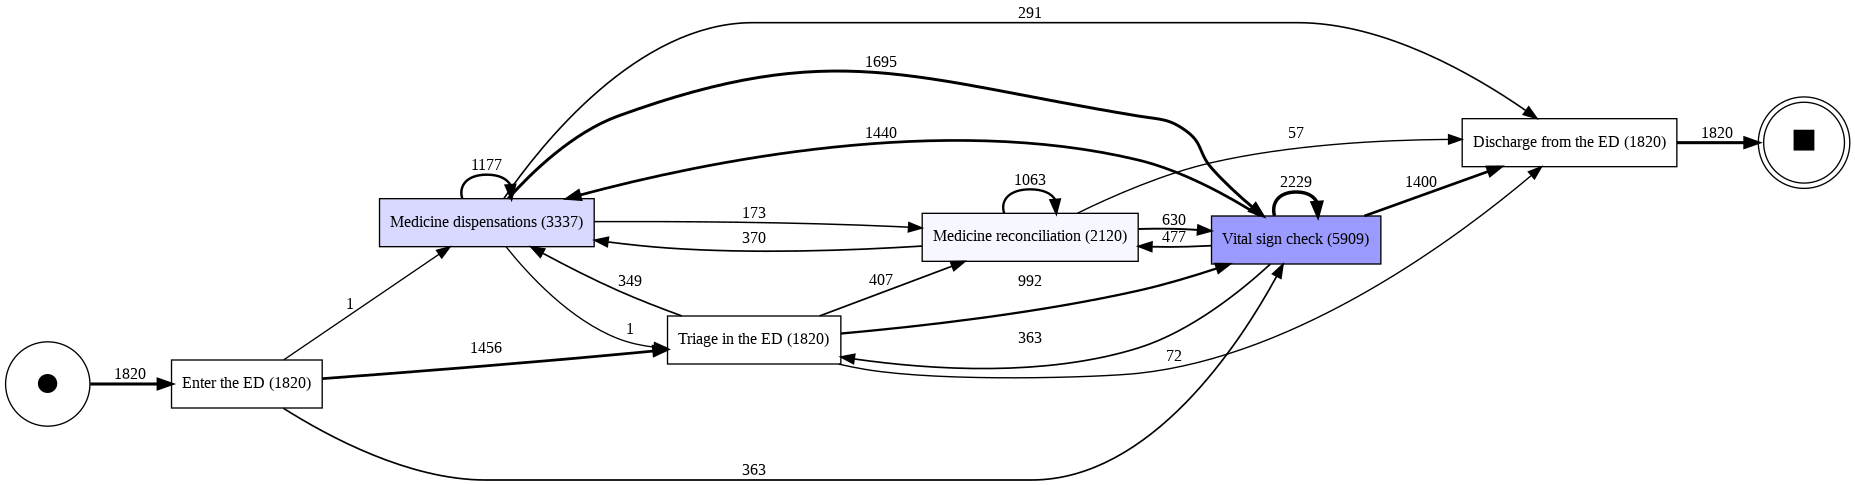

In [4]:
# --- BLOCK 4: DFG DISCOVERY ---
df_standard = pd.DataFrame(df.copy())
df_standard['time:timestamp'] = pd.to_datetime(df_standard['time:timestamp'], utc=True).dt.tz_localize(None)

print("Generating Frequency Map...")
dfg, start_activities, end_activities = pm4py.discover_dfg(df_standard)
pm4py.view_dfg(dfg, start_activities, end_activities)

print("\nGenerating Performance Map...")
try:
    dfg_perf = pm4py.discover_performance_dfg(df_standard)
    pm4py.view_performance_dfg(dfg_perf[0], start_activities, end_activities)
except Exception as e:
    print(f"Error generating Performance DFG: {e}")
    pm4py.view_dfg(dfg, start_activities, end_activities, format='png')


Model 1: Heuristics Net (Focus on main flows)


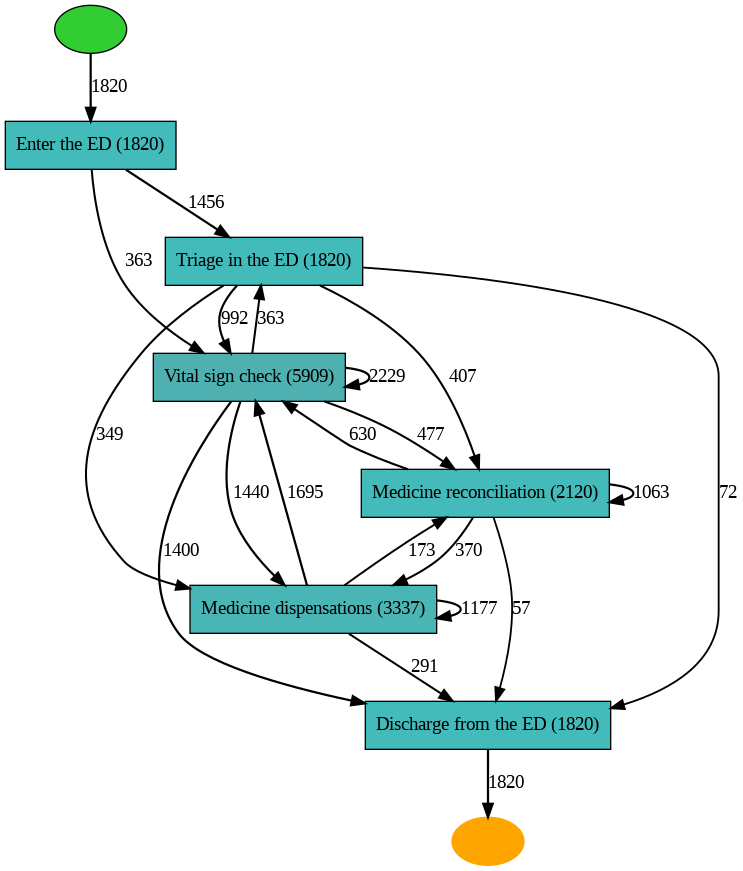


Model 2: Inductive Miner (Formal Petri Net)


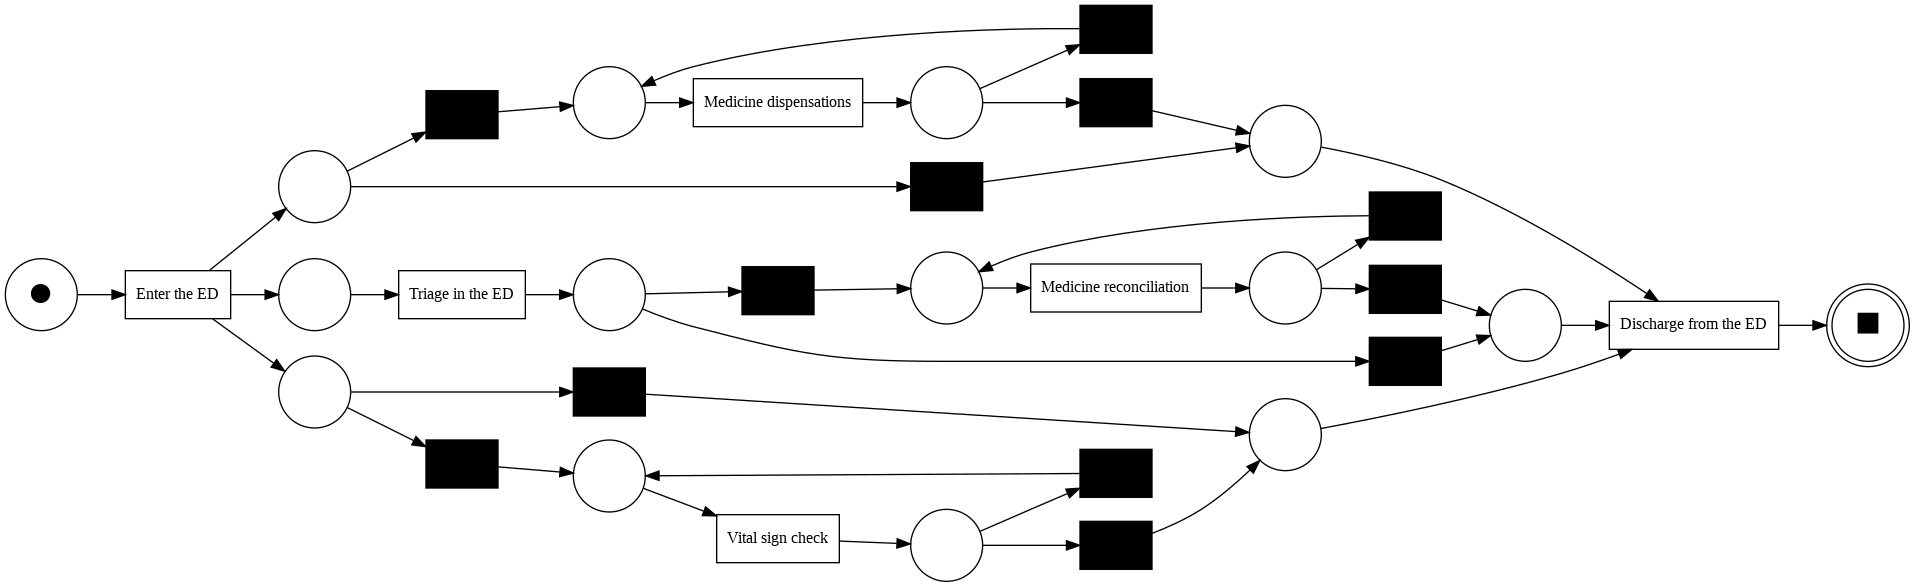


Model 3: Simplified Petri Net (Top 20% variants only)


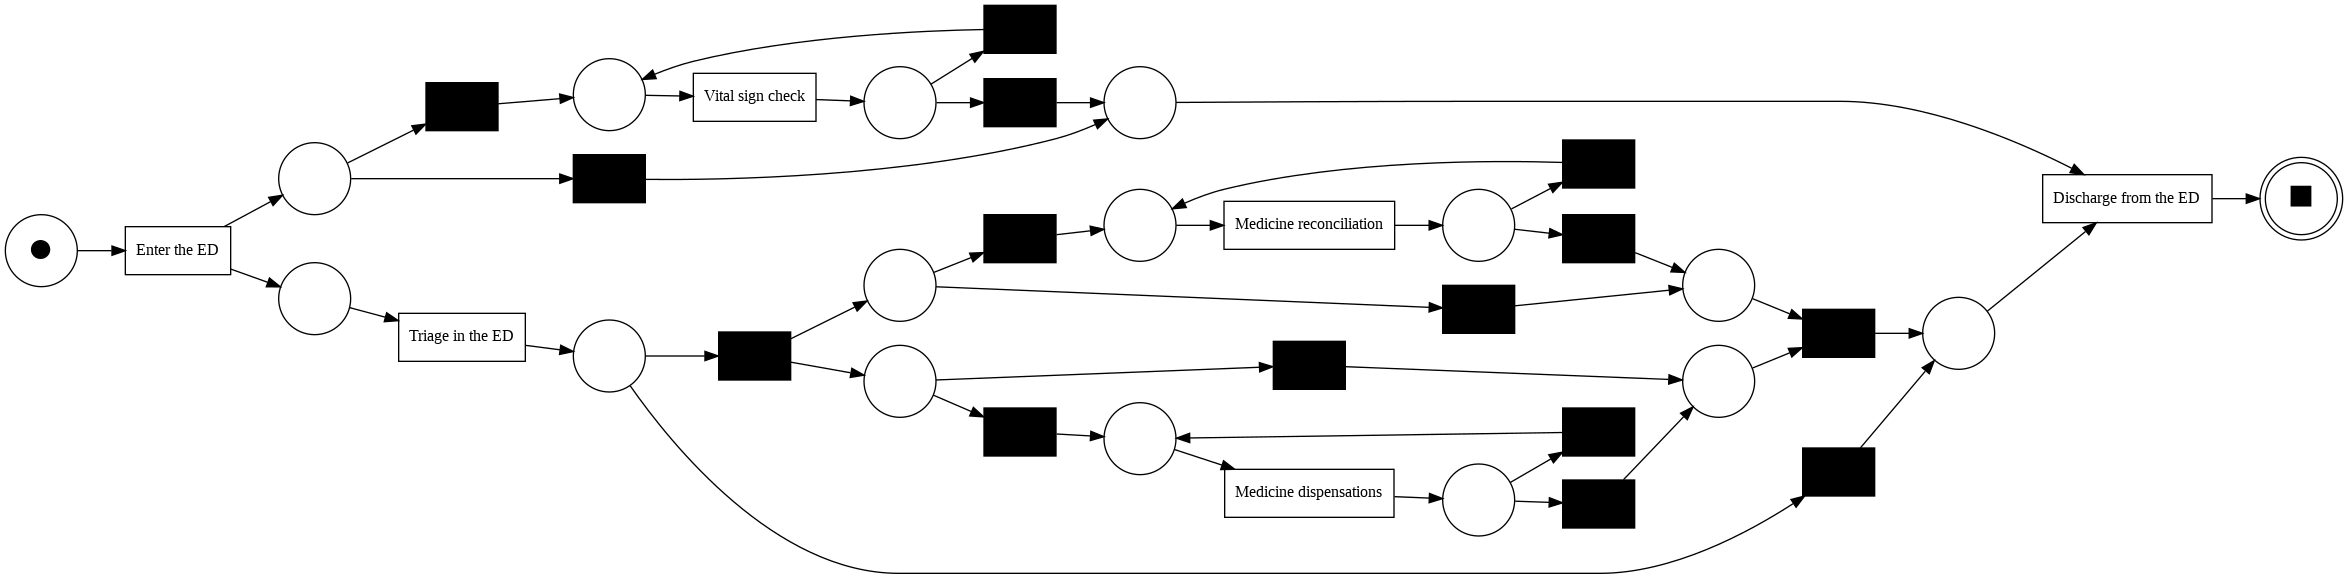

In [5]:
# --- BLOCK 5: PETRI NETS ---
print("Model 1: Heuristics Net (Focus on main flows)")
heu_net = pm4py.discover_heuristics_net(df, dependency_threshold=0.5, and_threshold=0.65, loop_two_threshold=0.5)
pm4py.view_heuristics_net(heu_net)

print("\nModel 2: Inductive Miner (Formal Petri Net)")
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(df)
pm4py.view_petri_net(net, initial_marking, final_marking)

top_20_perc_variants = variants_df.head(int(len(variants_df)*0.2))['Variant'].tolist()
filtered_log_top = pm4py.filter_variants(df, top_20_perc_variants)

print(f"\nModel 3: Simplified Petri Net (Top 20% variants only)")
net_simple, im_simple, fm_simple = pm4py.discover_petri_net_inductive(filtered_log_top)
pm4py.view_petri_net(net_simple, im_simple, fm_simple)


/tmp/ipython-input-1148817221.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Clinical_Status', data=medical_df_exploded, order=medical_df_exploded['Clinical_Status'].value_counts().index, palette="RdYlGn_r")


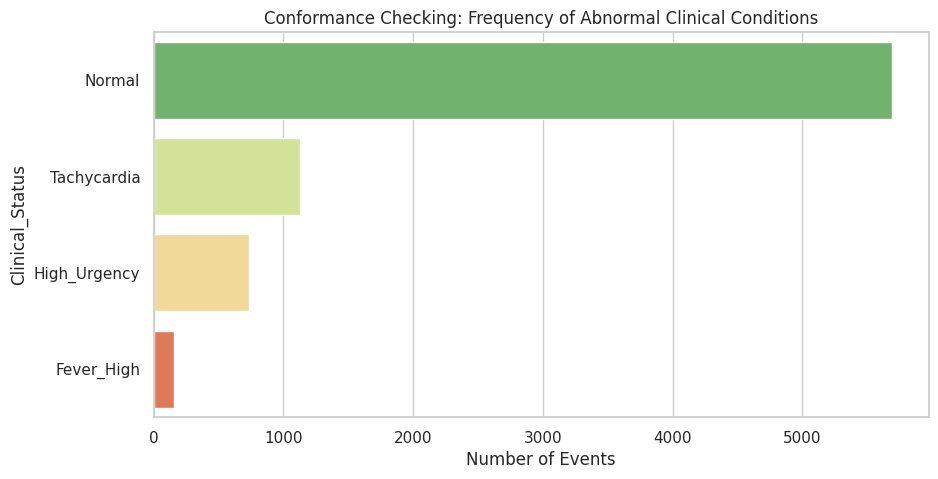

/tmp/ipython-input-1148817221.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Is_Critical', y='Lead_Time_Hours', data=case_perf, palette="Set1")


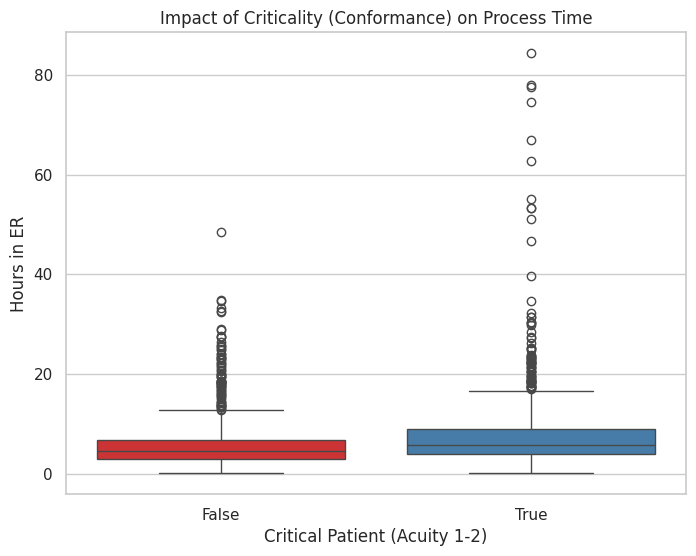

Analysis completed: Verified process respect for clinical priority.


In [6]:
# --- BLOCK 6: CLINICAL CONFORMANCE CHECKING ---
def check_medical_rules(row):
    violations = []
    if pd.notnull(row.get('temperature')) and row['temperature'] >= 100:
        violations.append("Fever_High")
    if pd.notnull(row.get('heartrate')) and row['heartrate'] > 100:
        violations.append("Tachycardia")
    if pd.notnull(row.get('acuity')) and row['acuity'] <= 2:
        violations.append("High_Urgency")
    return violations if len(violations) > 0 else ["Normal"]

medical_df = df.dropna(subset=['temperature', 'heartrate', 'acuity'], how='all').copy()

if not medical_df.empty:
    medical_df['Clinical_Status'] = medical_df.apply(check_medical_rules, axis=1)
    medical_df_exploded = medical_df.explode('Clinical_Status')

    plt.figure(figsize=(10, 5))
    sns.countplot(y='Clinical_Status', data=medical_df_exploded, order=medical_df_exploded['Clinical_Status'].value_counts().index, palette="RdYlGn_r")
    plt.title('Conformance Checking: Frequency of Abnormal Clinical Conditions')
    plt.xlabel('Number of Events')
    plt.show()

    critical_cases = medical_df[medical_df['acuity'] <= 2]['case:concept:name'].unique()
    df['Is_Critical'] = df['case:concept:name'].isin(critical_cases)
    case_perf = df.groupby(['case:concept:name', 'Is_Critical'])['time:timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds()/3600).reset_index(name='Lead_Time_Hours')

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Is_Critical', y='Lead_Time_Hours', data=case_perf, palette="Set1")
    plt.title('Impact of Criticality (Conformance) on Process Time')
    plt.xlabel('Critical Patient (Acuity 1-2)')
    plt.ylabel('Hours in ER')
    plt.show()
    print("Analysis completed: Verified process respect for clinical priority.")
else:
    print("Warning: Medical columns missing.")

/tmp/ipython-input-2026028624.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Patient_Pattern', y='Lead_Time', data=case_attributes, palette="muted", inner="quartile")


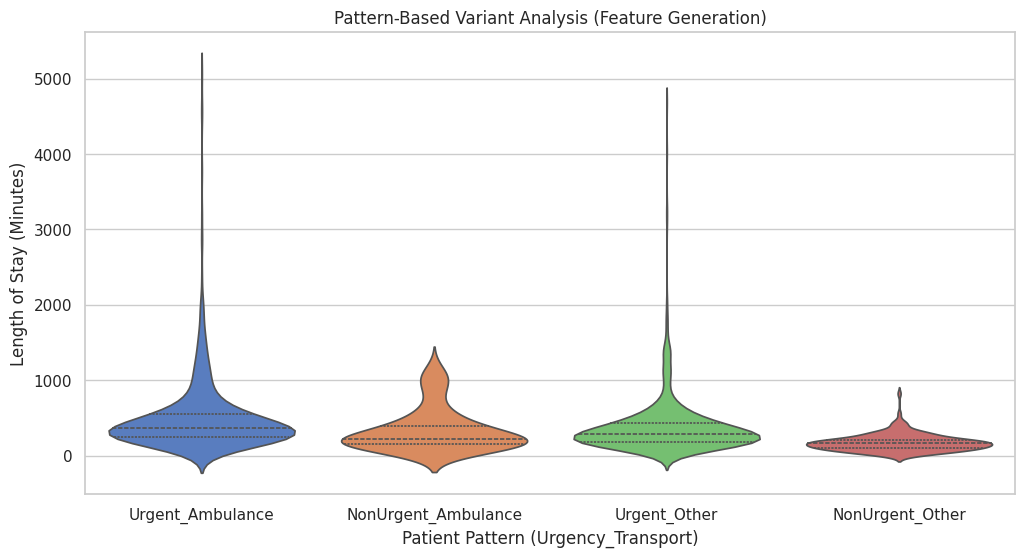


--- Statistics by Pattern ---
                     count        mean         std        min     25%    50%  \
Patient_Pattern                                                                
NonUrgent_Ambulance   54.0  343.501852  287.461742  41.916667  157.25  222.5   
NonUrgent_Other      151.0  174.788079  113.055833   6.000000  104.50  162.0   
Urgent_Ambulance     652.0  507.896881  504.959732  49.233333  245.00  363.0   
Urgent_Other         963.0  381.259623  379.547353   4.000000  185.50  293.0   

                        75%     max  
Patient_Pattern                      
NonUrgent_Ambulance  397.25  1187.0  
NonUrgent_Other      214.00   824.0  
Urgent_Ambulance     556.00  5065.0  
Urgent_Other         437.00  4688.0  


In [7]:
# --- BLOCK 7: PATTERN-BASED VARIANT ANALYSIS ---
def define_pattern(row):
    acuity_label = "Urgent" if row['acuity'] <= 3 else "NonUrgent"
    transport_label = "Ambulance" if str(row['arrival_transport']).upper() == "AMBULANCE" else "Other"
    return f"{acuity_label}_{transport_label}"

case_attributes = df.groupby('case:concept:name').first().reset_index()
case_attributes['Patient_Pattern'] = case_attributes.apply(define_pattern, axis=1)
case_attributes['Lead_Time'] = df.groupby('case:concept:name')['time:timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds()/60).values

plt.figure(figsize=(12, 6))
sns.violinplot(x='Patient_Pattern', y='Lead_Time', data=case_attributes, palette="muted", inner="quartile")
plt.title('Pattern-Based Variant Analysis (Feature Generation)')
plt.ylabel('Length of Stay (Minutes)')
plt.xlabel('Patient Pattern (Urgency_Transport)')
plt.show()

print("\n--- Statistics by Pattern ---")
print(case_attributes.groupby('Patient_Pattern')['Lead_Time'].describe())

--- TOP 10 MEDICAL VARIANTS (Pattern-Based Feature Generation) ---
Medical_Variant
HighBP                     1066
HighHR + HighBP             327
Normal Vitals               284
HighHR                       58
Fever + HighHR + HighBP      38
Fever + HighBP               24
Fever + HighHR               12
Fever                        11
Name: count, dtype: int64


/tmp/ipython-input-488938334.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Lead_Time_Mins', y='Medical_Variant', data=plot_data, order=top_variants, palette="Spectral")


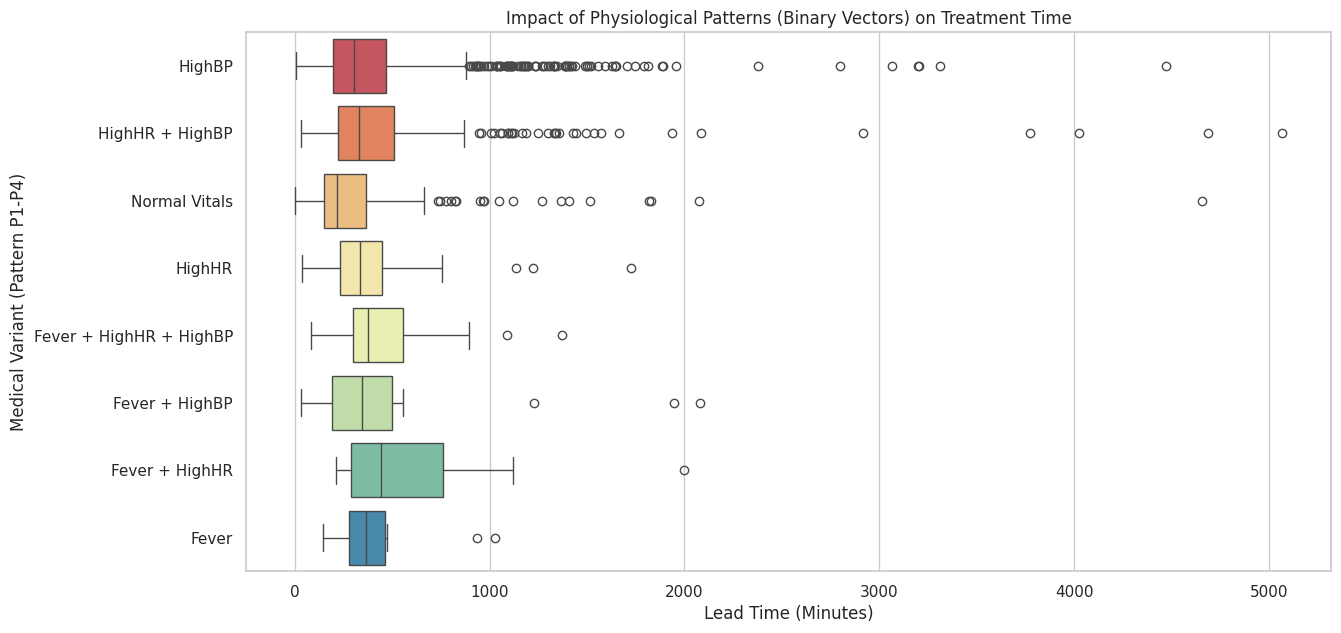


--- VECTOR ENCODING EXAMPLE ---
  case:concept:name  temperature  heartrate Vector_Code  Medical_Variant
0          30005370         98.1       90.0        0001           HighBP
1          30011087          NaN        NaN        0000    Normal Vitals
2          30016618         98.3      114.0        0101  HighHR + HighBP
3          30022872         98.4      188.0        0101  HighHR + HighBP
4          30023012         97.8       73.0        0001           HighBP


In [8]:
# --- BLOCK 8: MEDICAL BINARY VECTORS ---
def calculate_medical_vector(row):
    p1 = 1 if pd.notnull(row.get('temperature')) and row['temperature'] >= 100 else 0
    p2 = 1 if pd.notnull(row.get('heartrate')) and row['heartrate'] > 100 else 0
    p3 = 1 if pd.notnull(row.get('o2sat')) and row['o2sat'] < 90 else 0
    p4 = 1 if pd.notnull(row.get('sbp')) and row['sbp'] > 120 else 0

    vector_code = f"{p1}{p2}{p3}{p4}"
    desc = []
    if p1: desc.append("Fever")
    if p2: desc.append("HighHR")
    if p3: desc.append("LowO2")
    if p4: desc.append("HighBP")
    variant_label = " + ".join(desc) if desc else "Normal Vitals"
    return pd.Series([vector_code, variant_label])

case_vitals = df.groupby('case:concept:name')[['temperature', 'heartrate', 'o2sat', 'sbp']].max().reset_index()
case_vitals[['Vector_Code', 'Medical_Variant']] = case_vitals.apply(calculate_medical_vector, axis=1)

case_lead_time = df.groupby('case:concept:name')['time:timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds()/60).reset_index(name='Lead_Time_Mins')
analysis_df = pd.merge(case_vitals, case_lead_time, on='case:concept:name')
variant_counts = analysis_df['Medical_Variant'].value_counts().head(10)

print("--- TOP 10 MEDICAL VARIANTS (Pattern-Based Feature Generation) ---")
print(variant_counts)

top_variants = variant_counts.index.tolist()
plot_data = analysis_df[analysis_df['Medical_Variant'].isin(top_variants)]

plt.figure(figsize=(14, 7))
sns.boxplot(x='Lead_Time_Mins', y='Medical_Variant', data=plot_data, order=top_variants, palette="Spectral")
plt.title('Impact of Physiological Patterns (Binary Vectors) on Treatment Time')
plt.xlabel('Lead Time (Minutes)')
plt.ylabel('Medical Variant (Pattern P1-P4)')
plt.show()

print("\n--- VECTOR ENCODING EXAMPLE ---")
print(analysis_df[['case:concept:name', 'temperature', 'heartrate', 'Vector_Code', 'Medical_Variant']].head(5))

--- REWORK ANALYSIS (Repeated Activities) ---
              concept:name  Cases_With_Rework  Rework_Percentage
2         Vital sign check               1322          72.637363
0   Medicine dispensations                764          41.978022
1  Medicine reconciliation                430          23.626374


/tmp/ipython-input-3768976386.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rework_Percentage', y='concept:name', data=rework_stats, palette="magma")


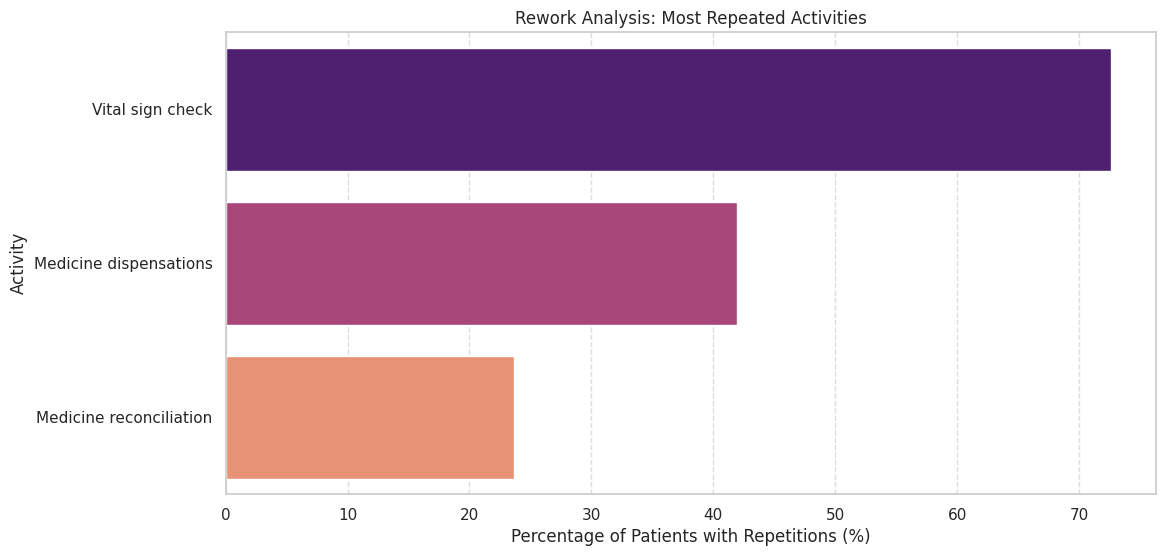

/tmp/ipython-input-3768976386.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Has_Rework', y='Lead_Time_Mins', data=temp_df, palette="coolwarm")


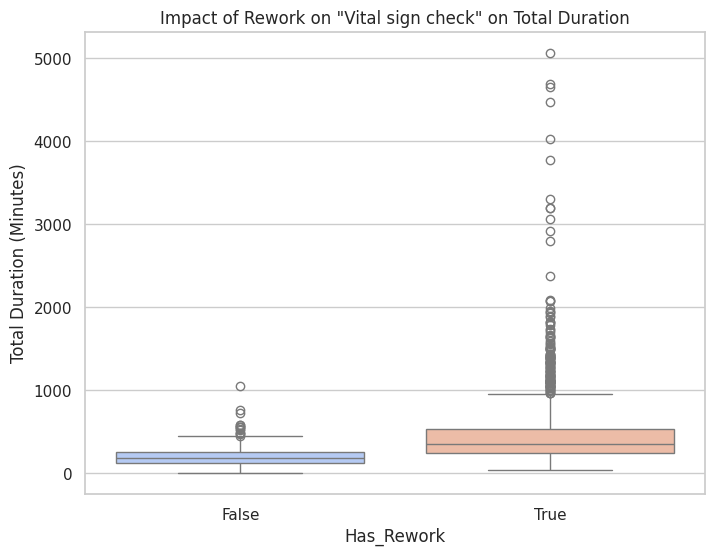

In [9]:
# --- BLOCK 9: REWORK ANALYSIS ---
activity_counts = df.groupby(['case:concept:name', 'concept:name']).size().reset_index(name='Frequency')
rework_data = activity_counts[activity_counts['Frequency'] > 1]

total_cases = df['case:concept:name'].nunique()
rework_stats = rework_data.groupby('concept:name')['case:concept:name'].nunique().reset_index(name='Cases_With_Rework')
rework_stats['Rework_Percentage'] = (rework_stats['Cases_With_Rework'] / total_cases) * 100
rework_stats = rework_stats.sort_values(by='Rework_Percentage', ascending=False)

print("--- REWORK ANALYSIS (Repeated Activities) ---")
print(rework_stats)

plt.figure(figsize=(12, 6))
sns.barplot(x='Rework_Percentage', y='concept:name', data=rework_stats, palette="magma")
plt.title('Rework Analysis: Most Repeated Activities')
plt.xlabel('Percentage of Patients with Repetitions (%)')
plt.ylabel('Activity')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

top_rework_activity = rework_stats.iloc[0]['concept:name']
cases_with_rework = rework_data[rework_data['concept:name'] == top_rework_activity]['case:concept:name'].unique()
temp_df = df.groupby('case:concept:name').last().reset_index()
temp_df['Has_Rework'] = temp_df['case:concept:name'].isin(cases_with_rework)
case_durations_rework = df.groupby('case:concept:name')['time:timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds()/60).reset_index(name='Lead_Time_Mins')
temp_df = pd.merge(temp_df, case_durations_rework, on='case:concept:name')

plt.figure(figsize=(8, 6))
sns.boxplot(x='Has_Rework', y='Lead_Time_Mins', data=temp_df, palette="coolwarm")
plt.title(f'Impact of Rework on "{top_rework_activity}" on Total Duration')
plt.ylabel('Total Duration (Minutes)')
plt.show()

--- Starting optimization (K=1 to K=10) ---


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=1: Fitness=0.666, Precision=0.943 => F1=0.781


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=2: Fitness=0.971, Precision=0.790 => F1=0.871


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=3: Fitness=0.982, Precision=0.805 => F1=0.885


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=4: Fitness=0.873, Precision=0.958 => F1=0.913


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=5: Fitness=0.811, Precision=0.999 => F1=0.895


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=6: Fitness=0.863, Precision=0.986 => F1=0.921


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=7: Fitness=0.842, Precision=0.990 => F1=0.910


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=8: Fitness=0.842, Precision=0.990 => F1=0.910


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=9: Fitness=0.861, Precision=0.974 => F1=0.914


replaying log with TBR, completed traces ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3888 [00:00<?, ?it/s]

-> K=10: Fitness=0.861, Precision=0.974 => F1=0.914

[RESULT] The optimal number of variants is K = 6


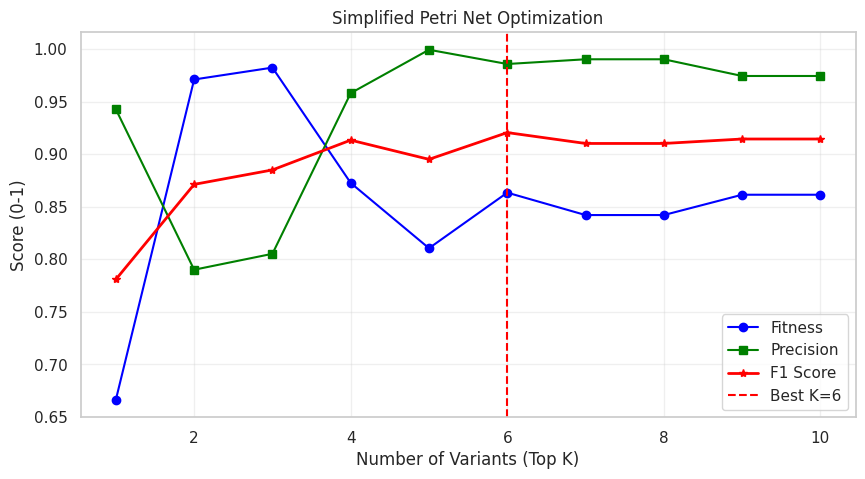

Generating Petri Net based on top 6 variants...


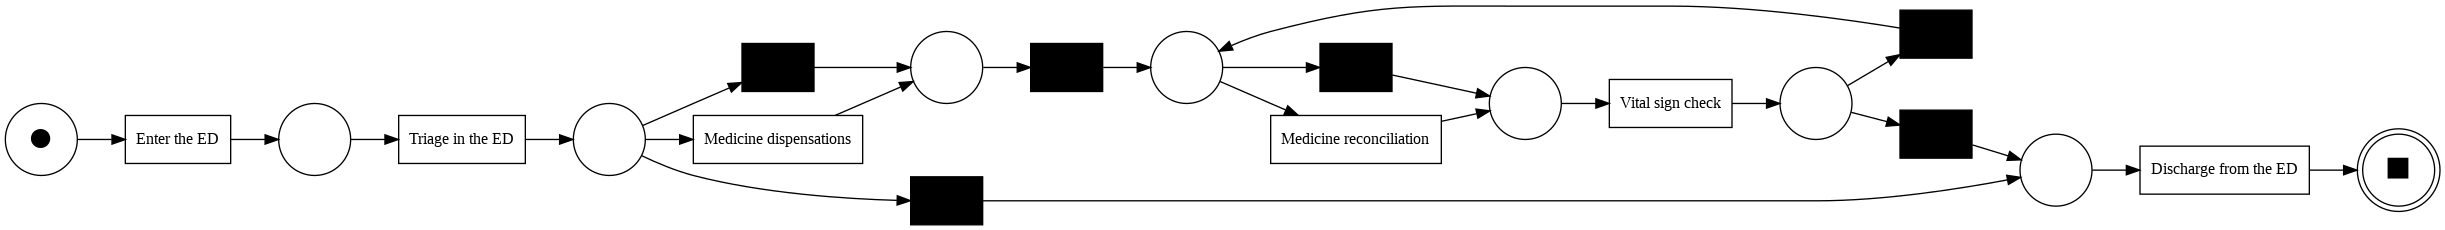

In [10]:
# --- BLOCK 10: OPTIMIZED SIMPLIFIED PETRI NET ---
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator

def find_best_k_variants(dataframe, k_min=1, k_max=10, step=1):
    print(f"--- Starting optimization (K={k_min} to K={k_max}) ---")
    results = []
    best_f1 = -1
    best_k = k_min
    full_log = pm4py.convert_to_event_log(dataframe)

    for k in range(k_min, k_max + 1, step):
        try:
            filtered_log = pm4py.filter_variants_top_k(full_log, k)
            net, im, fm = pm4py.discover_petri_net_inductive(filtered_log)
            fit_res = pm4py.fitness_token_based_replay(full_log, net, im, fm)
            fitness = fit_res['log_fitness']
            try:
                prec_res = pm4py.precision_token_based_replay(full_log, net, im, fm)
                precision = prec_res
            except:
                precision = 0.5

            f1 = 2 * (precision * fitness) / (precision + fitness) if (precision + fitness) > 0 else 0
            print(f"-> K={k}: Fitness={fitness:.3f}, Precision={precision:.3f} => F1={f1:.3f}")
            results.append({'k': k, 'Fitness': fitness, 'Precision': precision, 'F1': f1})

            if f1 > best_f1:
                best_f1 = f1
                best_k = k
        except Exception as e:
            print(f"Error with K={k}: {e}")
            continue
    return best_k, pd.DataFrame(results)

optimal_k, results_df = find_best_k_variants(df, k_min=1, k_max=10)
print(f"\n[RESULT] The optimal number of variants is K = {optimal_k}")

plt.figure(figsize=(10, 5))
plt.plot(results_df['k'], results_df['Fitness'], marker='o', label='Fitness', color='blue')
plt.plot(results_df['k'], results_df['Precision'], marker='s', label='Precision', color='green')
plt.plot(results_df['k'], results_df['F1'], marker='*', label='F1 Score', color='red', linewidth=2)
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Best K={optimal_k}')
plt.title('Simplified Petri Net Optimization')
plt.xlabel('Number of Variants (Top K)')
plt.ylabel('Score (0-1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Generating Petri Net based on top {optimal_k} variants...")
df_simplified = pm4py.filter_variants_top_k(df, optimal_k)
simple_net, simple_im, simple_fm = pm4py.discover_petri_net_inductive(df_simplified)
pm4py.view_petri_net(simple_net, simple_im, simple_fm, format='png')